In [1]:
import numpy as np
import numpy.matlib 
import math
import matplotlib.pyplot as plt
import csv
from matplotlib import cm

## INTRODUCTION: ADAM OPTIMIZER

Vanilla gradient descent can get easily trapped in local minima. For this reason, it is often appropriate to adopt more complex
gradient descent methods, as Adam or RMSProp. 
A description of the Adam algorithm is given below (image taken from the original paper) and can be found at 
[https://arxiv.org/pdf/1412.6980.pdf](https://arxiv.org/pdf/1412.6980.pdf).

<img src="Adam.png" width="800" height="600">


We can now try to understand the algorithm.
As you can see, Adam computes two exponential running average $m_t$ and $v_t$ of the gradient and the gradient squared respectively. In other words, for each parameter (each dimension of the gradient) the algorithm exploits a low pass filter to 
smooth the derivatives (and the derivatives squared) and reduce oscillations. If we focus on the meaning of $m_t$, we can understand that it also builds up momentum. In this way, the learning process can avoid to get stuck in some local minima of the error function.
The second momentum $v_t$ is on the square of the gradients. The definitiion of $\hat{m}_t$ and $\hat{v}_t$ corresponds to a transformation that is dependent on the training step (definition of $m_t$ and $v_t$ above) in order to reduce the effective learning rates as training progresses. Indeed, the denominators in the lef-hand side of the equations defining $m_t$ and $v_t$ are increasing as the time step t of the learning process rises. 
We can notice that the final update is $\propto \dfrac{\hat{m}_t}{\sqrt(\hat{v}_t)+\in}$. The latter term can be qualitatively understood by thinking that, if we were to compute $\dfrac{m_t}{\sqrt(v_t)}$ with $\beta_1=\beta_2$, we would obtain the $\mathrm{sign}(m_t)$ ($\mathrm{sign}$ is the sign function). Thus, the final ratio would not depend on the magnitude of the different gradients, feature that is desirable when a large number of parameters with different meanings and/or a highly compex system are considered. Of course, the purpose of $\in$ is to avoid instabilities when the gradient is $\approx 0$.

To show how Adam can accelerate and improve the training process, we can perform the following theoretical experiments.
In the examples below, we will consider mathematical functions and try to find their minima through gradient-descent.


In [2]:
## Let's define Adam

class Adam:

    def __init__(self, Params, beta1):
        
        N_dim=np.shape(np.shape(Params))[0] # It finds out if the parameters given are in a vector (N_dim=1) or a matrix (N_dim=2)
        
        # INITIALISATION OF THE MOMENTUMS
        if N_dim==1:
               
            self.N1=np.shape(Params)[0]
            
            self.mt=np.zeros([self.N1])
            self.vt=np.zeros([self.N1])
        
        if N_dim==2:
            
            self.N1=np.shape(Params)[0]
            self.N2=np.shape(Params)[1]
        
            self.mt=np.zeros([self.N1,self.N2])
            self.vt=np.zeros([self.N1,self.N2])
        
        # HYPERPARAMETERS OF ADAM
        self.beta1=beta1
        self.beta2=0.999
        
        self.epsilon=10**(-8)
        
        # COUNTER OF THE TRAINING PROCESS
        self.counter=0
        
        
    def Compute(self,Grads):
        
        # Compute the Adam updates by following the scheme above (beginning of the notebook)
        
        self.counter=self.counter+1
        
        self.mt=self.beta1*self.mt+(1-self.beta1)*Grads
        
        self.vt=self.beta2*self.vt+(1-self.beta2)*Grads**2
        
        mt_n=self.mt/(1-self.beta1**self.counter)
        vt_n=self.vt/(1-self.beta2**self.counter)
        
        New_grads=mt_n/(np.sqrt(vt_n)+self.epsilon)
        
        return New_grads

## Invariance to the magnitude 

In the first example, we will consider the function $$f(x,y)=e^{\alpha(x^2-y^2)}$$ 
,where $\alpha=0.05$.

<img src="Saddle.png" width="600" height="400">


The function has a saddle point in $0$, minimum along the x-axis and maximum along the y-axis.
We want to apply gradient-descent techniques from the initial point $(x_0,y_0)=(-5,-\in)$, where $\in$ is an arbitrary small value greater than zero. An effective gradient descent method should be able to move from the starting position and reach highly negative values of $y$.

Note that $\in$ is arbitrary close to zero and that the derivative of the funtion $\dfrac{\partial f}{\partial y}(x,0)=0$ $\,\forall x$. Moreover, the derivative in the starting point $(x_0,y_0)$ considered is 

$$\dfrac{\partial f}{\partial y}(-5,\in)=-2 \alpha f(-5,\in)\in\, \approx-2 \alpha f(-5,0)\in$$ 
Thus, $\in$ will lineraly rescale the magnitude of the starting derivative across the y-axis.

We will now see how, thanks to the invariance of Adam with respect to the magnitude, the technique can minimise the surface considered despite the small value of $\in$ adopted. This will show the robustness of Adam with respect to the initial conditions for the considered case.


In [3]:
# This cell defines f(x,y). The input are the x and y data points considered.
# The outputs are f(x,y) and the derivatives of f with respect to x and y.

def Saddle(x,y):
    
    z=np.exp(0.05*(x**2-y**2))
    z_X=np.exp(0.05*(x**2-y**2))*0.05*2*x
    z_Y=-np.exp(0.05*(x**2-y**2))*0.05*2*y
    
    return z,z_X,z_Y

The cell below performs the training loop. 

The following observations are important:

1. For a specific value of epsilon, also vanilla gradient descent can move across the y-axis by selecting a higher learning rate


2. It is always possible to find an arbitrary small value of $\in$ for which vanilla gradient descent does not work


3. The learning trajectory achieved by Adam is not dependent on the choice of $\in$

<IPython.core.display.Javascript object>


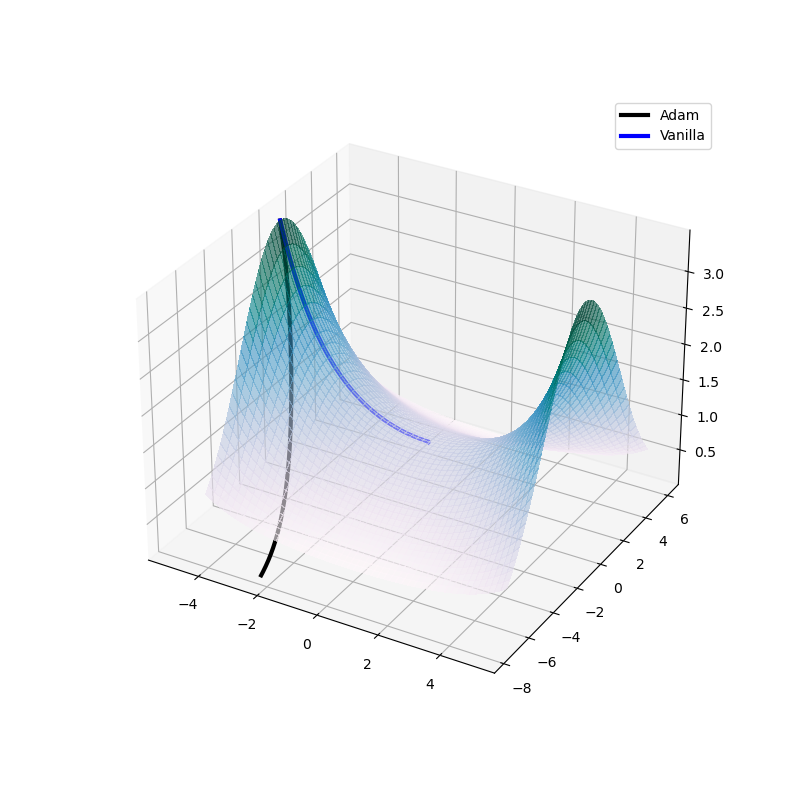

In [7]:
%matplotlib notebook

T=1000 # Number of iterations

## Value of epsilon
epsilon=-0.000001

# Initialise positions visited through gradient descent 
x=np.zeros([T])
y=np.zeros([T])
z=np.zeros([T])

# Set starting position
x[0]=-5
y[0]=epsilon
z[0],_,_=Saddle(x[0],y[0])

# Initialise positions visited through Adam
x_Adam=np.zeros([T])
y_Adam=np.zeros([T])
z_Adam=np.zeros([T])

# Set starting position
x_Adam[0]=-5
y_Adam[0]=epsilon
z_Adam[0],_,_=Saddle(x[0],y[0])

# Select the value for the first momentum
beta1=0.9
Adam_W=Adam(np.array([x_Adam[0],y_Adam[0]]),beta1)

# Select a learning rate for Adam (eta_A) and gradient descent (eta)
eta_A=0.01
eta=0.1

# Training loop
for t in range(T-1):
    
    # Compute derivatives for gradient descent
    der_x=Saddle(x[t],y[t])[1]
    der_y=Saddle(x[t],y[t])[2]
    
    # Updated the positions for gradient descent
    x[t+1]=x[t]-eta*der_x
    y[t+1]=y[t]-eta*der_y
    z[t+1]=Saddle(x[t+1],y[t+1])[0]
    
    # Compute derivatives for Adam
    der_x=Saddle(x_Adam[t],y_Adam[t])[1]
    der_y=Saddle(x_Adam[t],y_Adam[t])[2]
    
    # Use Adam to find the new update value
    der_A=Adam_W.Compute(np.array([der_x,der_y]))
    
    # Update the positions for Adam
    x_Adam[t+1]=x_Adam[t]-eta_A*der_A[0]
    y_Adam[t+1]=y_Adam[t]-eta_A*der_A[1]
    z_Adam[t+1]=Saddle(x_Adam[t+1],y_Adam[t+1])[0]
    

# Create the figure 

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, projection='3d')


x0=np.linspace(-5,5,500)
y0=np.linspace(-6,6,500)

X_plot, Y_plot = np.meshgrid(x0, y0)
Z_plot,_,_=Saddle(X_plot,Y_plot)

surf = ax.plot_surface(X_plot, Y_plot, Z_plot,cmap=cm.PuBuGn,
                       linewidth=0, antialiased=False,alpha=0.6)
line_A,=ax.plot(x_Adam,y_Adam,z_Adam,lw=3)
line_A.set_color("black")
line_B,=ax.plot(x,y,z,'b',lw=3)

ax.legend([line_A,line_B],['Adam', 'Vanilla'])

## Avoid Local minima

For this example, let's consider the 1-d Gramacy-Lee function 
$$f(x)=\dfrac{\sin(10\pi x)}{2x}+(x-1)^{4}$$
in the interval $x\in[0.8,2.5]$.

<img src="Gramacy_Lee.png" width="400" height="300">

As you can notice, the function has many local minima. 
We will start gradient descent from the point $x_0=2.5$.
In this case, we will initialise Adam with two different first order momentum by setting $\beta_1=0.9$ in one case, and $\beta_1=0.999$ for the other.
You will see how, thanks to the accumulated momentum, Adam can avoid getting trapped in local minima.


In [8]:
## Definition of the function, which returns f(x) and its derivative.

def Gramacy_Lee(x):
    
    y=np.sin(10*np.pi*x)/(2*x)+(x-1)**4
    y_prime=( 10*np.pi*np.cos(10*np.pi*x)*(2*x)-2*np.sin(10*np.pi*x) )/(4*x**2)+4*(x-1)**3
    
    return y, y_prime

In [9]:
# Training iterations
T=10000

# Initialise locations visited by vanilla gradient descent
x=np.zeros([T])
y=np.zeros([T])

# Set starting point
x[0]=2.5
y[0],_=Gramacy_Lee(x[0])

# Initialise locations visited by Adam with beta1=0.9
x_Adam=np.zeros([T])
y_Adam=np.zeros([T])

# Set starting point
x_Adam[0]=2.5
y_Adam[0],_=Gramacy_Lee(x[0])

# Initialise Adam with beta1=0.9
Adam_W=Adam([x_Adam[0]],0.9)

# Initialise locations visited by Adam with beta1=0.99
x1_Adam=np.zeros([T])
y1_Adam=np.zeros([T])

# Set starting point
x1_Adam[0]=2.5
y1_Adam[0],_=Gramacy_Lee(x[0])

# Initialise Adam with beta1=0.999
Adam_W1=Adam([x_Adam[0]],0.999)

# Initialise the learning rate
eta=0.01

for t in range(T-1):
    
    # Compute derivative for gradient descent and update positions
    der=Gramacy_Lee(x[t])[1]
    x[t+1]=x[t]-eta*der
    y[t+1]=Gramacy_Lee(x[t+1])[0]
    
    # Compute derivative for Adam with beta1=0.9 and update positions
    der=Gramacy_Lee(x_Adam[t])[1]
    x_Adam[t+1]=x_Adam[t]-eta*Adam_W.Compute(der)
    y_Adam[t+1]=Gramacy_Lee(x_Adam[t+1])[0]
    
    # Compute derivative for Adam with beta1=0.999 and update positions
    der=Gramacy_Lee(x1_Adam[t])[1]
    x1_Adam[t+1]=x1_Adam[t]-eta*Adam_W1.Compute(der)
    y1_Adam[t+1]=Gramacy_Lee(x1_Adam[t+1])[0]

The following cell creates an animation with the training process. Please let us know if you have technical difficulties 
running this animation.

<IPython.core.display.Javascript object>


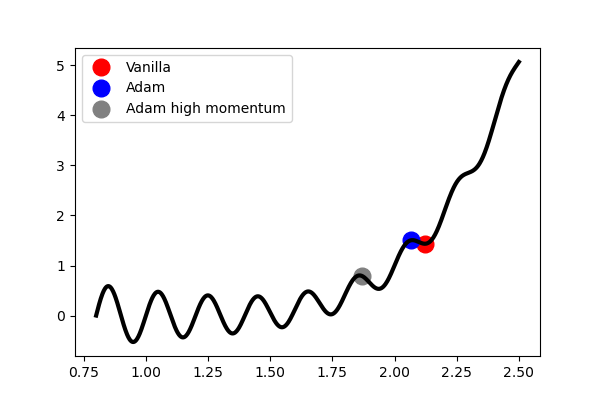

In [10]:
from matplotlib.animation import FuncAnimation
%matplotlib notebook

X=np.zeros([3,T])
Y=np.zeros([3,T])

X[0,:]=x
Y[0,:]=y
X[1,:]=x_Adam
Y[1,:]=y_Adam
X[2,:]=x1_Adam
Y[2,:]=y1_Adam
    

fig, ax = plt.subplots(figsize=(6, 4))
ax.xlim=(0.8, 2.5)
ax.ylim=(-1, 5)
particles1, = ax.plot([X[0,0]], [Y[0,0]], 'ro', ms=12)
particles2, = ax.plot([X[1,0]], [Y[1,0]], 'bo', ms=12)
particles3, = ax.plot([X[2,0]], [Y[2,0]], 'bo', ms=12)
particles3.set_color('grey')
ax.legend([particles1,particles2,particles3],['Vanilla','Adam','Adam high momentum'])

x0=np.linspace(0.8,2.5,1000)
y0,y0_prime=Gramacy_Lee(x0)

line, =ax.plot(x0, y0,'grey',lw=3)
line.set_color('black')

def init():
    
    particles1.set_data([], [])
    particles2.set_data([], [])
    particles3.set_data([], [])
    
    
    return particles1, particles2, particles3

def animate(i):

    particles1.set_data([X[0,i]],[Y[0,i]])
    particles2.set_data([X[1,i]],[Y[1,i]])
    particles3.set_data([X[2,i]],[Y[2,i]])

    return particles1, particles2, particles3

anim = FuncAnimation(fig, animate, init_func=init, frames=int(T/10), interval=1, blit=True)
plt.show()

## Matrix multiplication, avoiding for loops

For the next exercise (RL_ImmediateRewards), we will consider a different method to compute the network's activities and the gradients. 
In the previous lab (Lab1), we have used for loops to compute the response of the system for each sample in the minibatch.
Now, we will be using matrix multiplications. 

Let's consider the computation of the activities of a layer $\mathbf{y}$ (with $N_y$ nodes)

$$\mathbf{y}=f(\mathbf{x}\mathbf{W}+\mathbf{b})$$

where $\mathbf{x}$ corresponds to the activities of the previous layer (with $N_x$ nodes) and $\mathbf{b}$ are the biases. Note how, instead of 
a more standard mathematical notation where the product is written as $\mathbf{W}\mathbf{x}$, we wrote $\mathbf{x}\mathbf{W}$. 
The reason for this notation choice lies in how we manage our data.

As in standard tools like Tensorflow and Pytorch, the first dimension will always be the dimension containing the different samples in the minibatch. Thus, $\mathbf{x}$ will be of shape $[batch_{size},N_x]$ for the minibatch considered. 

Then, performing matrix multiplications $\mathbf{x}\mathbf{W}$ (notice that the weights are of shape $[N_{x},N_{y}]$) we will get outputs of shapes $[batch_{size},N_{y}]$ for all the samples in the minibatch at once. 

In the next lab, we will compute the activities and perform the updates of the parameters following this approach.
